<a href="https://colab.research.google.com/github/chiroiu96/ARL_Banking_Product_Recommender/blob/main/Copy_of_12_Recommendation_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Book Recommendation

The goal of this task is to implement a simple book recommendation system using embeddings in neural networks. 

We use the [Kaggle Goodbooks](https://www.kaggle.com/zygmunt/goodbooks-10k) data set.


## Read ratings

In [ ]:
import pandas as pd
ratings = pd.read_csv('https://github.com/mlcollege/rbi/raw/master/specializations/Deep-Learning/data/ratings.csv', sep=',')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


## Read books

In [ ]:
books = pd.read_csv('https://github.com/mlcollege/rbi/raw/master/specializations/Deep-Learning/data/books.csv', sep=',')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


## Prepare input data

In [ ]:
# merge ratings and book titles 
data = pd.merge(ratings, books[['id', 'title']], left_on='book_id', right_on='id')[['user_id', 'book_id', 'rating', 'title']]

# create new book and user ids
user_ids_map = dict([(old, new) for new, old in enumerate(data['user_id'].unique())])
book_ids_map = dict([(old, new) for new, old in enumerate(data['book_id'].unique())])
data['user_id'] = data['user_id'].map(lambda x: user_ids_map[x])
data['book_id'] = data['book_id'].map(lambda x: book_ids_map[x])

# count users and books
user_count = len(data['user_id'].unique())
book_count = len(data['book_id'].unique())
print ("Unique users: {}".format(user_count))
print ("Unique books: {}".format(book_count))

# preview the data
data.head()

Unique users: 53424
Unique books: 10000


,user_id,book_id,rating,title
0,0,0,5,"The Hunger Games (The Hunger Games, #1)"
1,1,0,3,"The Hunger Games (The Hunger Games, #1)"
2,2,0,5,"The Hunger Games (The Hunger Games, #1)"
3,3,0,4,"The Hunger Games (The Hunger Games, #1)"
4,4,0,4,"The Hunger Games (The Hunger Games, #1)"


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

## Define the model

This model simply computes dot product of a book dense vector with a user dense vector. Your task here is to replace this dot product with a sequence of Dense layers in order to add complexity to the model and get better results. Before adding Dense layers, you will need to concatenate both embeddings using the Concatenate layer.

In [ ]:
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense, Dropout
from keras.models import Model

book_input = Input(shape=(1))
book_embedding = Embedding(book_count, 6)(book_input)
book_vec = Flatten()(book_embedding)

user_input = Input(shape=(1))
user_embedding = Embedding(user_count, 6)(user_input)
user_vec = Flatten()(user_embedding)

#TODO Replace Dot product with a sequence of Dense layers
#prod = Dot(axes=1)([book_vec, user_vec])
conc = Concatenate(axis=1)([book_vec, user_vec])
drop1 = Dropout(rate=0.5)(conc)
d1 = Dense(64, activation="tanh")(drop1)
output = Dense(1, activation="relu")(d1)
model = Model([user_input, book_input], output)
model.compile('adam', 'mse')

print (model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 6)         60000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 6)         320544      input_2[0][0]                    
_______________________________________________________________________________________

## Train the model

In [ ]:
history= model.fit([train['user_id'], train['book_id']], [train['rating']], 
          validation_data=([test['user_id'], test['book_id']], [test['rating']]),
          batch_size=512, epochs=10, verbose=1)

Epoch 1/10
1534/1534 [==============================] - 9s 6ms/step - loss: 1.5440 - val_loss: 0.7431
Epoch 2/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.7456 - val_loss: 0.7185
Epoch 3/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.7204 - val_loss: 0.7117
Epoch 4/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.7079 - val_loss: 0.7093
Epoch 5/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.6985 - val_loss: 0.7047
Epoch 6/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.6891 - val_loss: 0.7037
Epoch 7/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.6839 - val_loss: 0.7029
Epoch 8/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.6805 - val_loss: 0.7028
Epoch 9/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.6764 - val_loss: 0.7031
Epoch 10/10
1534/1534 [==============================] - 9s 6ms/step - loss: 0.672

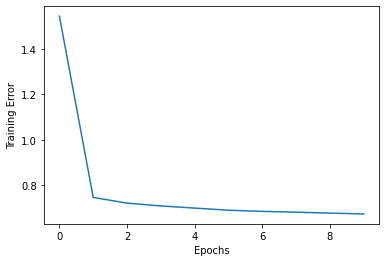

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.show()

### Evaluate the model

Measure mean squared error and mean absolute error evaluation metrics on both train and test data sets. Compute the mean and standard deviation of the target values.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict([test['user_id'], test['book_id']])
print ("Test mean: {}, std: {}".format(np.mean([test['rating']]), np.std([test['rating']])))
print("Test Root mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(test['rating'].tolist(), y_pred))))
print("Test Mean absolute error: {:.2f}".format(mean_absolute_error(test['rating'].tolist(), y_pred)))

Test mean: 3.858448093220339, std: 0.9834167947707816
Test Root mean squared error: 0.84
Test Mean absolute error: 0.65


In [ ]:
y_pred = model.predict([train['user_id'], train['book_id']])
print("Train Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(train['rating'].tolist(), y_pred)))
print("Train Mean absolute error: %.2f"
      % mean_absolute_error(train['rating'].tolist(), y_pred))

Train Root mean squared error: 0.78
Train Mean absolute error: 0.60


In [ ]:
for i in range(20):
  print("Predicted rating: " ,y_pred[i][0])
  print("Real rating: ", test['rating'].iloc[i])
  print()

Predicted rating:  3.1953738
Real rating:  4

Predicted rating:  3.3988233
Real rating:  3

Predicted rating:  4.512289
Real rating:  5

Predicted rating:  3.844872
Real rating:  3

Predicted rating:  3.9779656
Real rating:  4

Predicted rating:  4.0639772
Real rating:  5

Predicted rating:  3.740774
Real rating:  3

Predicted rating:  3.248302
Real rating:  4

Predicted rating:  3.5891366
Real rating:  3

Predicted rating:  3.8821938
Real rating:  4

Predicted rating:  4.5764236
Real rating:  3

Predicted rating:  3.0779839
Real rating:  4

Predicted rating:  4.5215783
Real rating:  5

Predicted rating:  3.0448008
Real rating:  4

Predicted rating:  4.2467246
Real rating:  5

Predicted rating:  3.8902056
Real rating:  4

Predicted rating:  4.6129103
Real rating:  4

Predicted rating:  4.138179
Real rating:  5

Predicted rating:  4.657558
Real rating:  4

Predicted rating:  3.6652648
Real rating:  5

